## Automatic simulation

In this simulation we go directly from the patient coordinates to the MRI coordinates

In [102]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random


In [103]:
# creating 4 points in patient coordinates

z = 200 # head length (about 20cm)
x = 250 # menton to top of head (about 25cm)
y = 150 # head bredth (about 15cm)


points = np.array(
[
    [-x,-y,z],
    [-x,y,z],
    [x,y,z],
    [x,-y,z],
])





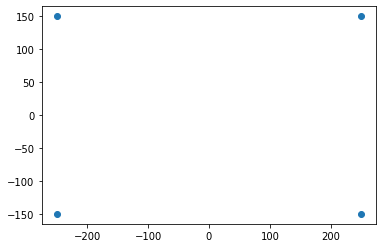

In [104]:
plt.figure()
plt.scatter(points[:,0], points[:,1])
plt.show()

## projecting points from 3D to 2D

In [105]:
intrinsics = np.loadtxt('calibration/intrinsics.txt')
distortion = np.loadtxt('calibration/distortion.txt')

print("Intrinsics are:" + str(intrinsics))
print("Distortion coefficients are:" + str(distortion))


Intrinsics are:[[664.6329766    0.         931.53151205]
 [  0.         663.83211807 520.64004697]
 [  0.           0.           1.        ]]
Distortion coefficients are:[-4.0929449e-01  2.1631278e-01  1.1120000e-05  1.2712000e-03
 -7.2057120e-02]


In [106]:
def convert_points(p_13):
    p_113 = np.zeros((1,1,3))
    p_113[0][0][0] = p_13[0]
    p_113[0][0][1] = p_13[1]
    p_113[0][0][2] = p_13[2]
    return p_113

In [107]:
rvec = np.zeros((1,3))
tvec = np.zeros((1,3))

p_143 = np.zeros((1,4,3))

for idx, point in enumerate(points):
    p_143[:,idx ,:] = convert_points(point)


image_points, jacobian = cv2.projectPoints(p_143, rvec, tvec, intrinsics, distortion)

In [108]:
image_points = image_points.squeeze()
print(image_points)

[[ 590.70593181  315.33086881]
 [ 590.67821662  725.99720692]
 [1281.2560626   729.16169462]
 [1281.2283474   312.1663811 ]]


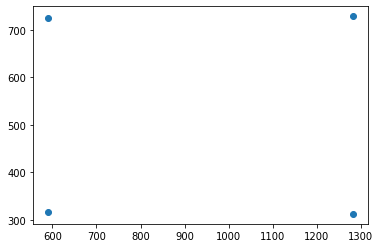

In [109]:
plt.figure()
plt.scatter(image_points[:,0], image_points[:,1])
plt.show()

# adding noise to image points

In [110]:
def add_noise_to_points(points_in, sigma):
    points_out = np.zeros((points_in.shape))
    for r in range(points_in.shape[0]):
        for c in range(points_in.shape[1]):
            points_out[r][c] = points_in[r][c] + random.normalvariate(0, sigma)
    return points_out

In [111]:
image_points_noisy = add_noise_to_points(image_points,0.25)

In [112]:
success, rotation_vector, translation_vector = cv2.solvePnP(points.astype('float32'), image_points_noisy.astype('float32'), intrinsics,distortion, flags=0 )


In [113]:
if success:
    print(f'rotation:, {rotation_vector}')
    print(f'translation:, {translation_vector}')
else:
    print('solution not found')

rotation:, [[-0.00144415]
 [ 0.01694678]
 [ 0.00013275]]
translation:, [[ -2.54961719]
 [ -0.26010229]
 [201.0085703 ]]


In [114]:
point_projected2D, jacobian = cv2.projectPoints(p_143, rotation_vector, translation_vector, intrinsics, distortion)
point_projected2D = point_projected2D.squeeze()
print(point_projected2D)


[[ 590.85510556  315.48618007]
 [ 590.54840232  725.94750218]
 [1281.53437819  729.54659408]
 [1281.33209916  312.06229631]]


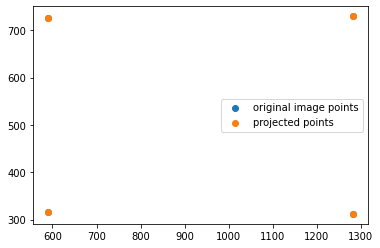

In [115]:
plt.figure()
plt.scatter(image_points[:,0], image_points[:,1])
plt.scatter(point_projected2D[:,0], point_projected2D[:,1])
#plt.scatter(image_points_noisy[:,0], image_points_noisy[:,1])
plt.legend(['original image points', 'projected points'])
plt.show()

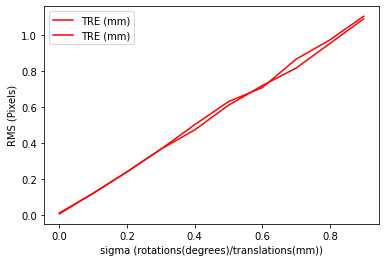

In [117]:

number_samples = 1000
x_values = []
y_values = []
for sigma_counter in range(0, 10, 1):
    sigma = float(sigma_counter) / float(10)
    rms = 0
    for i in range(number_samples):
        
        # add noise to image points
        image_points_noisy = add_noise_to_points(image_points,sigma)
        
        # try and match noisy 2D to original 3d object points
        success, rotation_vector, translation_vector = cv2.solvePnP(points.astype('float32'), image_points_noisy.astype('float32'), intrinsics,distortion, flags=0 )

        # project 3D original points using the found rotation and translation
        point_projected2D, jacobian = cv2.projectPoints(p_143, rotation_vector, translation_vector, intrinsics, distortion)
        point_projected2D = point_projected2D.squeeze()

        
        euclid_dist =  (point_projected2D[0] - image_points[0]) \
                     * (point_projected2D[0] - image_points[0]) \
                     + (point_projected2D[1] - image_points[1]) \
                     * (point_projected2D[1] - image_points[1]) 
        
        
        rms = rms + euclid_dist
    rms = rms / float(number_samples)
    rms = np.sqrt(rms)
    x_values.append(sigma)
    y_values.append(rms)
    
plt.plot(x_values, y_values, 'r', label='TRE (mm)')
plt.legend(loc='upper left')
plt.xlabel('sigma (rotations(degrees)/translations(mm))')
plt.ylabel('RMS (Pixels)')
plt.show()


In [ ]:
## adding noise to 3D

In [ ]:
## adding noise to both